### (1) DataFrame 생성

In [1]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [22]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### (2) 회귀선 그래프

독립변수: petal_length 컬럼 (input: x)

종속변수: petal_width 컬럼 (output: y)

In [12]:
iris_lr= iris[['petal_length', 'petal_width']]

In [18]:
# 훈련, 테스트 데이터 분리
from sklearn.model_selection import train_test_split
train, test= train_test_split(iris_lr, train_size=0.8)

In [19]:
xtrain= train['petal_length']
ytrain= train['petal_width']
xtest= test['petal_length']
ytest= test['petal_width']

In [50]:
print(xtrain.head(), '\n', type(xtrain), end='\n\n')
print(ytrain.head())

18     1.7
115    5.3
62     4.0
19     1.5
75     4.4
Name: petal_length, dtype: float64 
 <class 'pandas.core.series.Series'>

18     0.3
115    2.3
62     1.0
19     0.3
75     1.4
Name: petal_width, dtype: float64


In [75]:
import numpy as np
_xtrainf= xtrain.to_numpy
_xtrain= _xtrainf()
_xtrain= _xtrain.reshape(-1, 1)
# print(_xtrain)

_xtestf= xtest.to_numpy
_xtest= _xtestf()
_xtest= _xtest.reshape(-1, 1)

In [45]:
# 회귀 모델링
from sklearn import linear_model
regression= linear_model.LinearRegression()
trainModel= regression.fit(_xtrain, ytrain)

In [72]:
print(xtrain.name[:], regression.coef_)

petal_length [0.4154677]


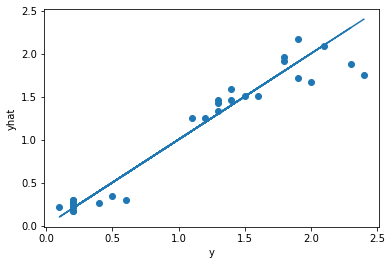

In [80]:
import matplotlib.pyplot as plt

fig= plt.figure()
ax= fig.add_subplot(111)
ax.scatter(ytest, ypred)
ax.set_ylabel('yhat')
ax.set_xlabel('y')
ax.plot(ytest, ytest)

### (3) Spark를 사용하여 회귀분석하고 계수 출력

In [81]:
import pyspark
myConf= pyspark.SparkConf()

spark= pyspark.sql.SparkSession\
.builder\
.master("local")\
.appName("myAPP")\
.config(conf=myConf)\
.getOrCreate()

In [82]:
irisDf= spark.createDataFrame(iris)

In [83]:
irisDf= irisDf.select('petal_length', 'petal_width')

In [86]:
irisDf.show(5)

+------------+-----------+
|petal_length|petal_width|
+------------+-----------+
|         1.4|        0.2|
|         1.4|        0.2|
|         1.3|        0.2|
|         1.5|        0.2|
|         1.4|        0.2|
+------------+-----------+
only showing top 5 rows



In [87]:
# 훈련, 테스트 데이터 분리
(trainDf, testDf)= irisDf.randomSplit([0.8, 0.2])

In [88]:
from pyspark.ml.feature import VectorAssembler
va= VectorAssembler(inputCols= ['petal_length'], outputCol='feature')

In [92]:
from pyspark.ml.regression import LinearRegression
lr= LinearRegression(featuresCol='feature', labelCol='petal_width', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [93]:
from pyspark.ml import Pipeline
pipeline= Pipeline(stages=[va, lr])

In [94]:
model= pipeline.fit(trainDf)
modelTrainDf= model.transform(trainDf)

In [95]:
print("계수: ", model.stages[-1].coefficients)

계수:  [0.2543850978272763]


### (4) 실제와 예측 출력

* sklearn

In [96]:
ypred= regression.predict(_xtest)

In [97]:
y_actual_pred= pd.DataFrame({'y': ytest, 'yhat': ypred.flatten()})

In [98]:
y_actual_pred.head()

,y,yhat
148,2.3,1.877103
82,1.2,1.253901
3,0.2,0.256779
85,1.6,1.503182
103,1.8,1.960196




* spark

In [99]:
modelTestDf= model.transform(testDf)

In [101]:
modelTestDf.select('petal_width', 'prediction').show()

+-----------+------------------+
|petal_width|        prediction|
+-----------+------------------+
|        0.1|0.6128512086667042|
|        0.2|0.6128512086667042|
|        0.2|0.6128512086667042|
|        0.2|0.6128512086667042|
|        0.1|0.6382897184494318|
|        0.1|0.6382897184494318|
|        0.2|0.6382897184494318|
|        0.2|0.6382897184494318|
|        0.3|0.6382897184494318|
|        0.2|0.6637282282321595|
|        0.4|0.6637282282321595|
|        1.1|1.0198673651903463|
|        1.4| 1.248813953234895|
|        1.0|  1.29969097280035|
|        1.2|1.3760065021485333|
|        1.5|1.4014450119312607|
|        1.5|1.4268835217139884|
|        1.8|1.5031990510621713|
|        1.8| 1.655830109758537|
|        2.1|1.7067071293239924|
+-----------+------------------+
only showing top 20 rows



### (5) 정확성 평가하고 출력

* sklearn

In [103]:
sk_acc= regression.score(_xtest, ytest)

In [111]:
print('sklearn\' accuracy: {:.2f}%'.format(sk_acc*100))

sklearn' accuracy: 93.32%


* spark

In [108]:
from pyspark.ml.evaluation import RegressionEvaluator
evauator= RegressionEvaluator(labelCol='petal_width', predictionCol='prediction', metricName='r2')

In [112]:
sp_acc= evauator.evaluate(modelTestDf)
print('spark\' accuracy: {:.2f}%'.format(sp_acc*100))

spark' accuracy: 37.78%
